# ML Data Analysis


Create `DataFrame`'s from extracted and processed datasets.

In [1]:
%load_ext autoreload
%autoreload 2
from data.load import load_parquet

tempanomalies_df = load_parquet('tempanomalies')
land_cover_df = load_parquet('land_cover_types')
co2_df = load_parquet('co2')

print("Tempanomalies DataFrame:", tempanomalies_df.columns, tempanomalies_df.size)
print("Land Cover DataFrame:", land_cover_df.columns, land_cover_df.size)
print("XCO2 DataFrame:", co2_df.columns, co2_df.size)

Tempanomalies DataFrame: Index(['time', 'lat', 'lon', 'tempanomaly'], dtype='object') 32000
Land Cover DataFrame: Index(['time', 'band', 'lat', 'lon', 'land_cover_type', 'spatial_ref',
       'land_cover_type_name'],
      dtype='object') 68602450
XCO2 DataFrame: Index(['sounding_id', 'xco2', 'time', 'lat', 'lon'], dtype='object') 116085


Extract necessary features for tempanomalies prediction. Merge data extracted from xco2 measurements and land cover type. `lat_range` and `lon_range` can be adjusted to more or less precise merging of `DataFrame`'s by location.

In [2]:
from datetime import timedelta
import numpy as np
from pandas import DataFrame

t_df = tempanomalies_df.dropna(inplace=False).copy()

prediction_time = max(list(map(lambda t: t.to_pydatetime(), t_df["time"]))) + timedelta(
    days=10
)
lat_range = 0.01
lon_range = 0.02

t_df["month"] = list(map(lambda t: t.to_pydatetime().month, t_df["time"]))
t_df["season"] = list(map(lambda t: ((t % 12) // 3) + 1, t_df["month"]))
t_df["year"] = list(map(lambda t: t.to_pydatetime().year, t_df["time"]))
t_df["month_sin"] = np.sin(2 * np.pi * t_df["month"] / 12)
t_df["month_cos"] = np.cos(2 * np.pi * t_df["month"] / 12)
t_df["time"] = list(map(lambda t: t.timestamp(), t_df["time"]))

co2_rows_candidates: list[DataFrame] = [
    co2_df[
        ((co2_df["lat"] + lat_range) >= row["lat"])
        & ((co2_df["lat"] - lat_range) <= row["lat"])
        & ((co2_df["lon"] + lon_range) >= row["lon"])
        & ((co2_df["lon"] - lon_range) <= row["lon"])
    ]
    .assign(delta=co2_df["lat"] - row["lat"] + co2_df["lon"] - row["lon"])
    .sort_values("delta", ascending=True)
    for _, row in t_df.iterrows()
]

# TODO: vectorizing or pandas sql to improve performance
t_df["co2"] = [
    (row.iloc[0]["xco2"] if row.size > 0 else None)
    for _, row in enumerate(co2_rows_candidates)
]
t_df.dropna(inplace=True)

land_types_rows_candidates: list[DataFrame] = [
    land_cover_df[
        ((land_cover_df["lat"] + lat_range) >= row["lat"])
        & ((land_cover_df["lat"] - lat_range) <= row["lat"])
        & ((land_cover_df["lon"] + lon_range) >= row["lon"])
        & ((land_cover_df["lon"] - lon_range) <= row["lon"])
        & (((land_cover_df["time"] + 1) == row["year"]) | ((land_cover_df["time"]) == row["year"]))
    ]
    .assign(delta=co2_df["lat"] - row["lat"] + co2_df["lon"] - row["lon"])
    .sort_values("delta", ascending=True)
    for _, row in t_df.iterrows()
]
t_df["land_cover_type"] = [
    row.iloc[0]["land_cover_type"] if row.size > 0 else None
    for row in land_types_rows_candidates
]
t_df["land_cover_type_year"] = [
    row.iloc[0]["time"] if row.size > 0 else None
    for row in land_types_rows_candidates
]
t_df.dropna(inplace=True)
t_df

,time,lat,lon,tempanomaly,month,season,year,month_sin,month_cos,co2,land_cover_type,land_cover_type_year
1226,1.579046e+09,45.0,21.0,1.85,1,1,2020,0.500000,0.866025,427.157166,4.0,2020.0
1248,1.579046e+09,49.0,25.0,4.78,1,1,2020,0.500000,0.866025,424.856415,12.0,2020.0
1277,1.579046e+09,55.0,23.0,8.13,1,1,2020,0.500000,0.866025,418.637604,8.0,2020.0
1278,1.579046e+09,55.0,25.0,8.27,1,1,2020,0.500000,0.866025,417.388275,10.0,2020.0
1326,1.581725e+09,45.0,21.0,4.47,2,1,2020,0.866025,0.500000,427.157166,4.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7878,1.752538e+09,55.0,25.0,2.29,7,3,2025,-0.500000,-0.866025,417.388275,10.0,2024.0
7926,1.755216e+09,45.0,21.0,2.62,8,3,2025,-0.866025,-0.500000,427.157166,4.0,2024.0
7948,1.755216e+09,49.0,25.0,1.59,8,3,2025,-0.866025,-0.500000,424.856415,12.0,2024.0
7977,1.755216e+09,55.0,23.0,0.48,8,3,2025,-0.866025,-0.500000,418.637604,5.0,2024.0


Train Gradient Boosting regression to predict future temperature anomalies. Track with MLflow.

In [3]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
import mlflow
import mlflow.sklearn as mls
from sklearn.model_selection import train_test_split

mlflow.set_experiment("Tempanomaly Prediction")

with mlflow.start_run():
    X = np.array(t_df[["lat", "lon", "month_sin", "month_cos", "year", "co2", "land_cover_type", "land_cover_type_year"]])
    y = np.array(t_df["tempanomaly"])
    mls.autolog()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    params = {
        "n_estimators": 800,
        "max_depth": 4,
        "min_samples_split": 10,
        "learning_rate": 0.01,
        "loss": "huber",
        "max_features": "sqrt",
        "random_state": 42,
    }
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    score: float = reg.score(X_test, y_test)
    print("Score:", score)
    mse = mean_squared_error(y_test, reg.predict(X_test))
    print("MSE on test set:", mse)

    
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", score)

    mlflow.log_params(reg.get_params())

    mls.log_model(sk_model=reg, name="gradient_boosting_model", input_example = X_train[:5])


Score: 0.43292624382254374
MSE on test set: 2.9042646547379523


Predict anomalies for the amount of the next `months_to_predict` since the last day in the dataset.

In [4]:

months_to_predict = 12
future_points = pd.DataFrame(
    {
        "lat": np.tile(t_df["lat"], months_to_predict),
        "lon": np.tile(t_df["lon"], months_to_predict),
        "month": np.repeat(
            [
                (prediction_time + timedelta(days=30 * i)).month
                for i in range(months_to_predict)
            ],
            len(t_df),
        ),
        "year": np.repeat(
            [
                (prediction_time + timedelta(days=30 * i)).year
                for i in range(months_to_predict)
            ],
            len(t_df),
        ),
        "co2": np.tile(t_df["co2"], months_to_predict), 
        "land_cover_type": np.tile(t_df["land_cover_type"], months_to_predict),
        "land_cover_type_year": np.tile(t_df["land_cover_type_year"], months_to_predict),
    }
)
future_points["month_sin"] = np.sin(2 * np.pi * future_points["month"] / 12)
future_points["month_cos"] = np.cos(2 * np.pi * future_points["month"] / 12)

X_future = future_points[["lat", "lon", "month_sin", "month_cos", "year", "co2", "land_cover_type", "land_cover_type_year"]].values
future_points["tempanomaly"] = reg.predict(X_future)
future_points["time"] = [
    (prediction_time + timedelta(days=30 * i)).timestamp()
    for i in range(months_to_predict)
    for _ in range(len(t_df))
]

Merge known data with predicted.

In [5]:
from datetime import datetime
from visualization.plotting import plot_temp_stats

merged = pd.concat([t_df, future_points], axis=0)
merged["time"] = [datetime.fromtimestamp(t) for t in merged["time"]]
merged

,time,lat,lon,tempanomaly,month,season,year,month_sin,month_cos,co2,land_cover_type,land_cover_type_year
1226,2020-01-15 01:00:00,45.0,21.0,1.850000,1,1.0,2020,0.500000,0.866025,427.157166,4.0,2020.0
1248,2020-01-15 01:00:00,49.0,25.0,4.780000,1,1.0,2020,0.500000,0.866025,424.856415,12.0,2020.0
1277,2020-01-15 01:00:00,55.0,23.0,8.130000,1,1.0,2020,0.500000,0.866025,418.637604,8.0,2020.0
1278,2020-01-15 01:00:00,55.0,25.0,8.270000,1,1.0,2020,0.500000,0.866025,417.388275,10.0,2020.0
1326,2020-02-15 01:00:00,45.0,21.0,4.470000,2,1.0,2020,0.866025,0.500000,427.157166,4.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3259,2026-07-21 00:00:00,55.0,25.0,0.211839,7,NaN,2026,-0.500000,-0.866025,417.388275,10.0,2024.0
3260,2026-07-21 00:00:00,45.0,21.0,2.670145,7,NaN,2026,-0.500000,-0.866025,427.157166,4.0,2024.0
3261,2026-07-21 00:00:00,49.0,25.0,1.678904,7,NaN,2026,-0.500000,-0.866025,424.856415,12.0,2024.0
3262,2026-07-21 00:00:00,55.0,23.0,0.706029,7,NaN,2026,-0.500000,-0.866025,418.637604,5.0,2024.0


See how predicted data continued the one we retrieved from GISTEMP.

2025/11/18 18:23:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '40fd140c2fa8437c9a57422ad272b8fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
2025/11/18 18:23:38 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics

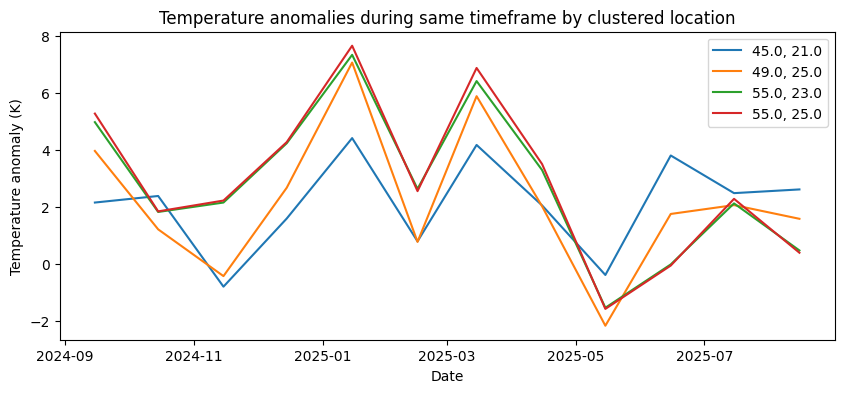

In [6]:
previous = t_df.copy()
previous["time"] = [datetime.fromtimestamp(t) for t in previous["time"]]
plot_temp_stats(previous[((previous["year"] == 2024) & (previous["month"] > 8)) | (previous["year"] == 2025)], save = False)

2025/11/18 18:23:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '074633ba1b5a491bb09653db05ed377d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
2025/11/18 18:23:40 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metric

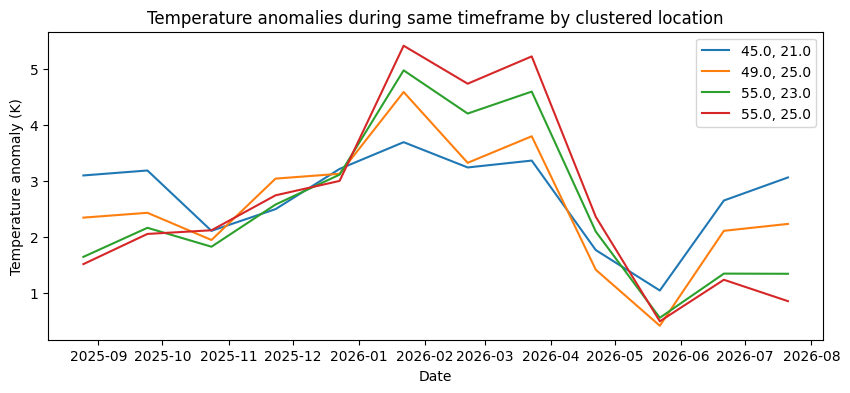

In [7]:
future = future_points.copy()
future["time"] = [datetime.fromtimestamp(t) for t in future["time"]]
plot_temp_stats(future, save = False)

2025/11/18 18:23:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c3c932f2e3e5432280e672a4a8c8dad2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
2025/11/18 18:23:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metric

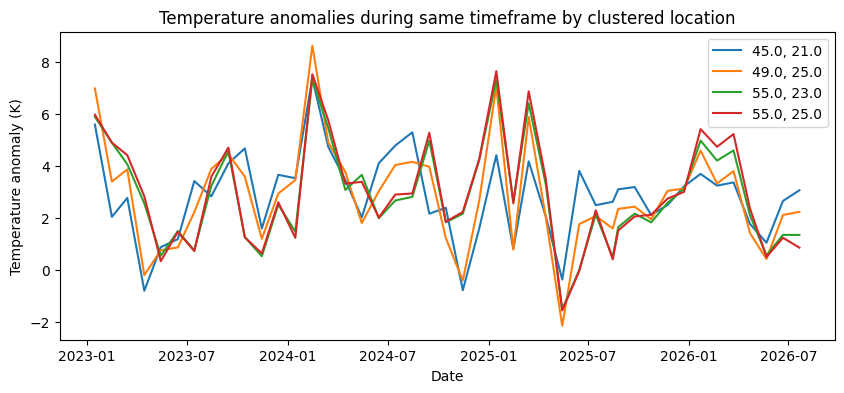

In [8]:
plot_temp_stats(merged[merged["year"] > 2022], save = False)